## Importing libiraies

In [202]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import warnings
import gc
import scikitplot as skplt
from matplotlib.ticker import EngFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
warnings.filterwarnings('ignore')
gc.collect()

33663

## Helper functions for plotting

In [10]:
# histogram/bar graph of data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 100]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 100, facecolor = 'w', edgecolor = 'k')
    plt.rcParams.update({'font.size': 10})
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
            plt.gca().yaxis.set_major_formatter(EngFormatter())
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})' ,  fontsize = 22)
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [12]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df["Age"] = pd.to_numeric(df["Age"], downcast='integer')
    df["Height"] = pd.to_numeric(df["Height"], downcast='integer')
    df["Weight"] = pd.to_numeric(df["Weight"], downcast='integer')
    df = df.select_dtypes(include =[np.number, np.float64]) 
  #  df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    print (df.columns)
    columnNames = list(df)
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i in range (len(columnNames)):
        for j in range (len(columnNames)):
            ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


### loading data 

In [13]:
nRowsRead = None # None to show all
df1 = pd.read_csv('D:\Ahmed\Study\Forth year\Second Term\Advanced Data Analysis\Project\data/athlete_events.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'athlete_events.csv'
nRow, nCol = df1.shape
del df1[("ID")]
print(f'There are {nRow} rows and {nCol} columns')

There are 271116 rows and 15 columns


In [204]:
df1.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### graphs of sampled columns:

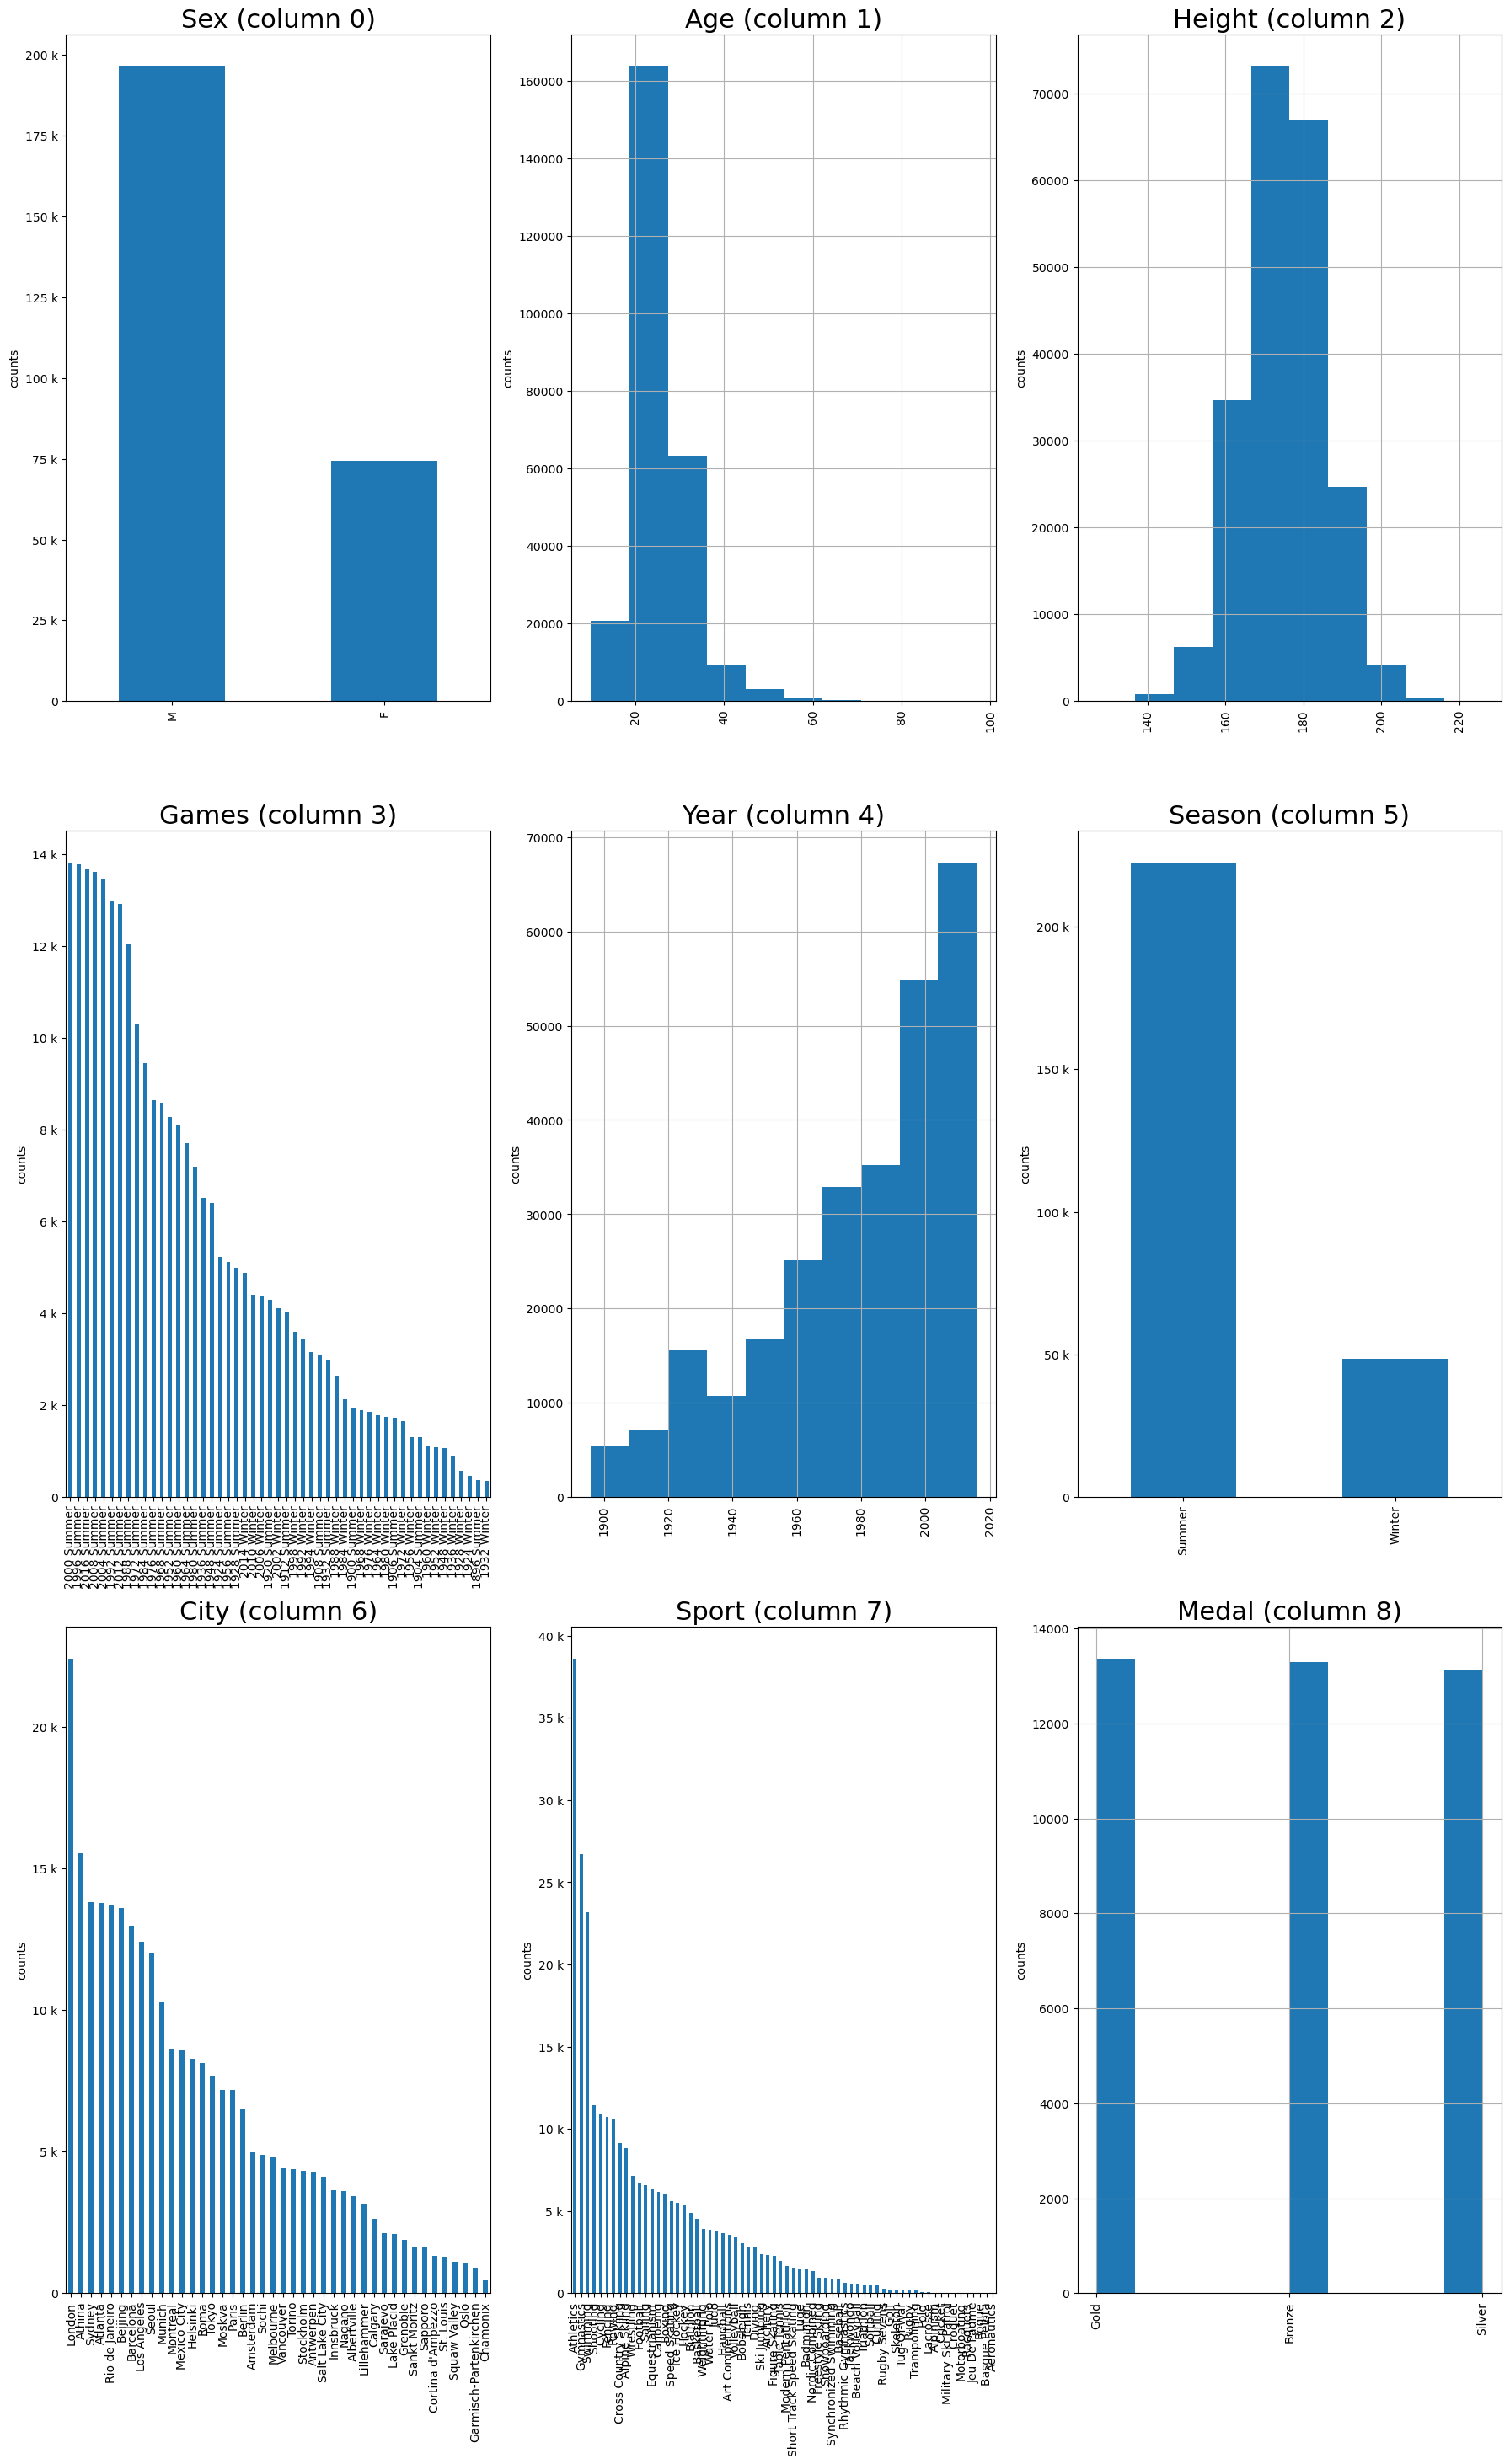

In [18]:
plotPerColumnDistribution(df1, 15, 3)

Scatter and density plots:

Index(['Age', 'Height', 'Weight', 'Year'], dtype='object')


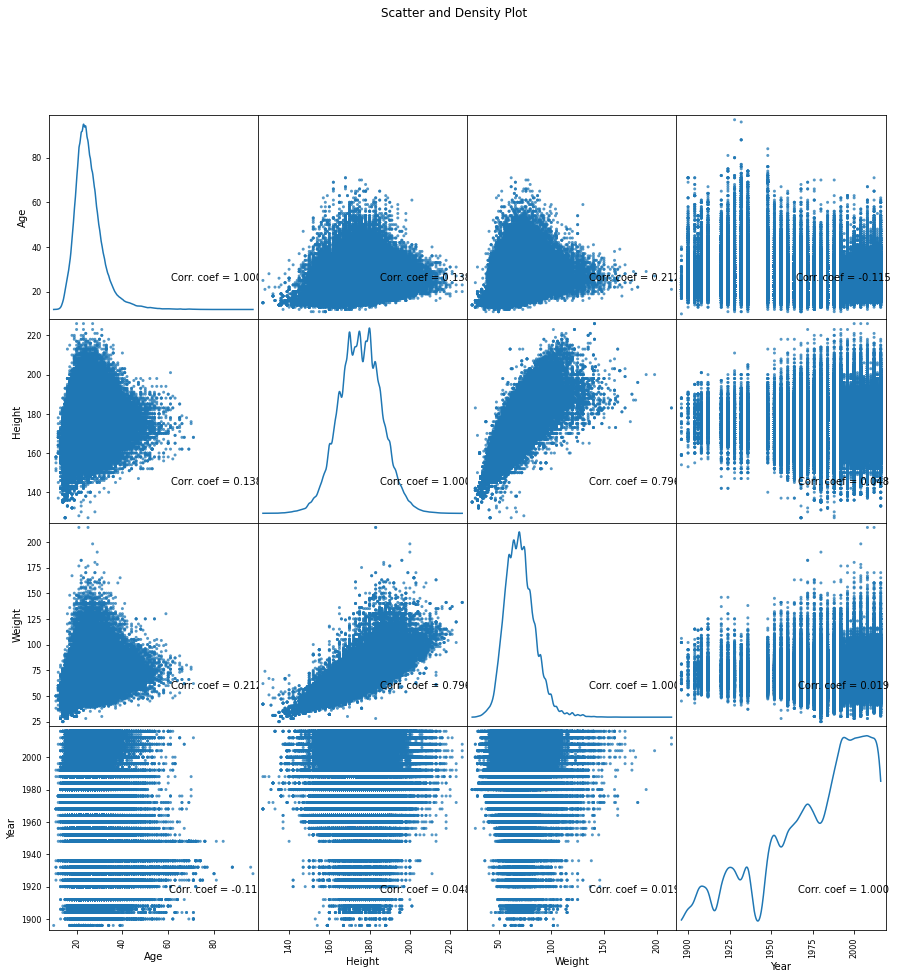

In [20]:
plotScatterMatrix(df1, 15, 10)

Pie chart

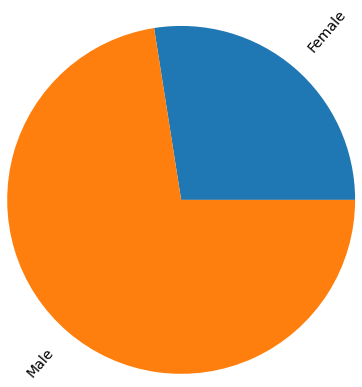

In [24]:
pie = np.array([df1.Sex.values.tolist() ,df2.region.values.tolist()])
Age = df1["Sex"].dropna()
Sex = Age.map(lambda x:0 if x =="M" else 1 )
F   = Sex.sum() 
M   = len(Sex) -F
Sex = [F, M]
labels = ["Female", "Male"]
plt.pie(Sex , radius=2, labels=labels, rotatelabels=True, textprops={'fontsize': 14})
plt.show() 

### ML model:

In [145]:
column = ["Sex","Age", "Height","Weight","Sport","Medal"]
data = df1[column]
data.head(5)


,Sex,Age,Height,Weight,Sport,Medal
0,M,24.0,180.0,80.0,Basketball,NaN
1,M,23.0,170.0,60.0,Judo,NaN
2,M,24.0,NaN,NaN,Football,NaN
3,M,34.0,NaN,NaN,Tug-Of-War,Gold
4,F,21.0,185.0,82.0,Speed Skating,NaN


### data pre-processing

In [146]:
data.isna().any() 

Sex       False
Age        True
Height     True
Weight     True
Sport     False
Medal      True
dtype: bool

In [147]:
data.Sport.value_counts()

Athletics        38624
Gymnastics       26707
Swimming         23195
Shooting         11448
Cycling          10859
                 ...  
Racquets            12
Jeu De Paume        11
Roque                4
Basque Pelota        2
Aeronautics          1
Name: Sport, Length: 66, dtype: int64

In [148]:
valueCounts = data.Sport.value_counts()
data = pd.DataFrame(filter( lambda x : valueCounts[ x[-2] ] > 5000 , data.values ) , columns=data.columns )
data

,Sex,Age,Height,Weight,Sport,Medal
0,M,24.0,NaN,NaN,Football,NaN
1,F,21.0,185.0,82.0,Speed Skating,NaN
2,F,21.0,185.0,82.0,Speed Skating,NaN
3,F,25.0,185.0,82.0,Speed Skating,NaN
4,F,25.0,185.0,82.0,Speed Skating,NaN
...,...,...,...,...,...,...
205713,M,23.0,168.0,76.0,Hockey,NaN
205714,M,27.0,168.0,76.0,Hockey,NaN
205715,M,21.0,175.0,75.0,Football,NaN
205716,M,24.0,183.0,72.0,Rowing,NaN


In [149]:
data["Medal"] = data["Medal"].fillna(0)

In [150]:
data

,Sex,Age,Height,Weight,Sport,Medal
0,M,24.0,NaN,NaN,Football,0
1,F,21.0,185.0,82.0,Speed Skating,0
2,F,21.0,185.0,82.0,Speed Skating,0
3,F,25.0,185.0,82.0,Speed Skating,0
4,F,25.0,185.0,82.0,Speed Skating,0
...,...,...,...,...,...,...
205713,M,23.0,168.0,76.0,Hockey,0
205714,M,27.0,168.0,76.0,Hockey,0
205715,M,21.0,175.0,75.0,Football,0
205716,M,24.0,183.0,72.0,Rowing,0


In [151]:
data["Age"] = data["Age"].fillna(data.Age.mean())
data["Height"] = data["Height"].fillna(data.Height.mean())
data["Weight"] = data["Weight"].fillna(data.Weight.mean())

In [152]:
data.Height.mean()

174.77539607402824

In [153]:
data.isna().any()

Sex       False
Age       False
Height    False
Weight    False
Sport     False
Medal     False
dtype: bool

In [154]:
medal_label = {"Medal" : 1 , "No_medal" : 0 }
sport_label = {v:i for i,v in enumerate(data.Sport.unique()) }
sex_label = {v:i for i,v in enumerate(data.Sex.unique()) }

In [155]:
data["Medal"] = data["Medal"].map(lambda x: 0 if x == 0 else 1)

In [156]:
data["Sport"] = data["Sport"].map(lambda x: sport_label[x] )
data["Sex"] = data["Sex"].map(lambda x: sex_label[x] )

In [206]:
data.head()

,Sex,Age,Height,Weight,Sport,Medal
0,0,0.241935,2.596774,0.983871,1,1
1,0,0.306452,2.870968,1.080645,6,0
2,1,0.322581,2.657668,0.963431,7,0
3,0,0.112903,2.580645,0.822581,3,0
4,0,0.193548,2.657668,0.963431,3,1


In [158]:
age_scaler = MinMaxScaler()
age_scaler.fit(data.Age.values.reshape(-1, 1))
h_scaler = MinMaxScaler()
h_scaler.fit(data.Height.values.reshape(-1, 1))
w_scaler = MinMaxScaler()
w_scaler.fit(data.Weight.values.reshape(-1, 1))

MinMaxScaler()

In [159]:
data["Age"] = age_scaler.transform(data["Age"].values.reshape(-1, 1))
data["Height"] = age_scaler.transform(data["Height"].values.reshape(-1, 1))
data["Weight"] = age_scaler.transform(data["Weight"].values.reshape(-1, 1))

In [160]:
len(data)

205718

In [161]:
nandata = data[ data.Medal == 0 ].sample(30000)


In [163]:
medaldata = data[ data.Medal == 1 ].sample(30000, replace = True )

In [165]:
data = pd.concat([nandata , medaldata])

In [207]:
data.head()

,Sex,Age,Height,Weight,Sport,Medal
0,0,0.241935,2.596774,0.983871,1,1
1,0,0.306452,2.870968,1.080645,6,0
2,1,0.322581,2.657668,0.963431,7,0
3,0,0.112903,2.580645,0.822581,3,0
4,0,0.193548,2.657668,0.963431,3,1


In [167]:
len(data)

60000

In [170]:
data.reset_index(drop = True , inplace = True)

In [173]:
data.head()

,Sex,Age,Height,Weight,Sport,Medal
0,0,0.225806,2.657668,0.963431,0,0
1,0,0.225806,2.629032,0.854839,7,0
2,0,0.290323,2.657668,0.963431,6,0
3,0,0.225806,2.951613,1.177419,17,0
4,0,0.338710,2.709677,1.080645,17,0


In [174]:
data = data.sample( frac = 1 ).reset_index(drop = True)

In [175]:
data.head()

,Sex,Age,Height,Weight,Sport,Medal
0,0,0.241935,2.596774,0.983871,1,1
1,0,0.306452,2.870968,1.080645,6,0
2,1,0.322581,2.657668,0.963431,7,0
3,0,0.112903,2.580645,0.822581,3,0
4,0,0.193548,2.657668,0.963431,3,1


In [182]:
x = data[["Sex", "Age", "Height", "Weight", "Sport"]] 
y = data["Medal"]
x_train, x_test, y_train, y_test = train_test_split( x , y, test_size=0.20, random_state=42)

In [183]:
X_train

,Sex,Age,Height,Weight,Sport
48572,0,0.354839,2.657668,0.963431,7
38696,0,0.306452,2.822581,0.903226,6
13611,1,0.177419,2.645161,0.887097,3
35213,0,0.112903,2.657668,0.645161,11
31766,0,0.209677,2.532258,0.887097,5
...,...,...,...,...,...
54343,1,0.129032,2.419355,0.564516,7
38158,1,0.161290,2.580645,0.983871,3
860,0,0.532258,2.657668,0.963431,6
15795,0,0.241935,2.657668,0.963431,7


### logistic regression:

In [186]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
pred =  clf.predict(x_test)
conf_mat = confusion_matrix(y_test, pred)
print(conf_mat)
clf.score(x_test, y_test)

[[3565 2481]
 [2755 3199]]


0.5636666666666666

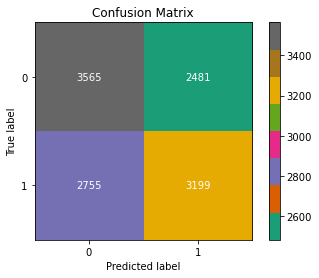

In [200]:
skplt.metrics.plot_confusion_matrix(y_test, pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Dark2",
                                    );

In [203]:
print('Precision                                   : %.3f'%precision_score(y_test, pred))
print('Recall                                      : %.3f'%recall_score(y_test, pred))
print('F1-Score                                    : %.3f'%f1_score(y_test, pred))

Precision                                   : 0.563
Recall                                      : 0.537
F1-Score                                    : 0.550
